## Radiometric terrain correction qualitative assessment 

[sarsen](https://github.com/bopen/sarsen) radiometric correction implements the gamma flatting algorithm proposed by Small, David (2011). [Flattening Gamma: Radiometric Terrain Correction for SAR Imagery. Geoscience and Remote Sensing, IEEE Transactions on. 49. 3081 - 3093. 10.1109/TGRS.2011.2120616](https://www.researchgate.net/publication/224230688_Flattening_Gamma_Radiometric_Terrain_Correction_for_SAR_Imagery)

In this notebook, we perform the same qualitative test done by the authors to evaluate the goodness of the gamma flattening correction. For an introduction to terrain correction, see [Customizable radiometric terrain corrections of Sentinel-1 products
](https://planetarycomputer.microsoft.com/docs/tutorials/customizable-rtc-sentinel1/).

### Install Dependencies and Imports
Additional dependencies: `sarsen==0.9.2`

In [1]:
# !pip install sarsen==0.9.2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["font.size"] = 14

In [3]:
import os
import tempfile

import numpy as np
import xarray as xr
from scipy.stats import gaussian_kde as kde
from sarsen import apps, geocoding, orbit, scene

import adlfs
import planetary_computer
import pystac_client
import stackstac
import rioxarray  # noqa: F401

plt.rcParams["figure.figsize"] = (10, 7)

### Processing definitions

In [4]:
# create a temporary directory where to store downloaded data
tmp_dir = tempfile.gettempdir()

# DEM path
dem_path = os.path.join(tmp_dir, "South-of-Redmond-10m.tif")

# path to Sentinel-1 input product in the Planetary Computer
product_folder = "GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048"  # noqa: E501

# band to be processed
measurement_group = "IW/VV"

tmp_dir

'/tmp'

#### Area of interest definition: South-of-Redmond (Seattle, US)

In [5]:
lon, lat = [-121.95, 47.04]
buffer = 0.2
bbox = [lon - buffer, lat - buffer, lon + buffer, lat + buffer]

#### DEMs discovery

Here we use the DEM with a 10-meter ground sample distance (GDS) available on the Planetary Computer. Note that **any DEM supported by GDAL/Proj can be used**.

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.  
As multiple DEMs acquired at different times are available in this area, we select the DEMs with 10-meter GDS and perform the average of the remaining DEMs along the time dimension.

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections="3dep-seamless", bbox=bbox, query={"gsd": {"eq": 10}}
)
items = search.item_collection()

Here we load the data into an xarray `DataArray` using stackstac.

In [7]:
# select DEMs with resolution 10 meters
dem_raster_all = stackstac.stack(items, bounds=bbox).squeeze()
dem_raster_all

<xarray.DataArray 'stackstac-17d335035c58cf69aa5cad36acefdf7c' (time: 4,
                                                                y: 4321, x: 4321)>
dask.array<getitem, shape=(4, 4321, 4321), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time             (time) datetime64[ns] 2018-02-02 2018-02-08 ... 2020-01-07
    id               (time) <U10 'n48w122-13' 'n47w122-13' ... 'n48w123-13'
    band             <U4 'data'
  * x                (x) float64 -122.2 -122.1 -122.1 ... -121.8 -121.8 -121.8
  * y                (y) float64 47.24 47.24 47.24 47.24 ... 46.84 46.84 46.84
    proj:epsg        int64 5498
    ...               ...
    threedep:region  <U7 'n40w130'
    proj:shape       object {10812}
    start_datetime   (time) <U20 '1952-01-01T00:00:00Z' ... '2017-09-14T00:00...
    end_datetime     (time) <U20 '2016-12-31T00:00:00Z' ... '2019-04-25T00:00...
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    epsg             int64 5498
Attributes:
    spec:        RasterSpec(epsg=5498, bounds=(-122.15000053746, 46.839907613...
    crs:         epsg:5498
    transform:   | 0.00, 0.00,-122.15|\n| 0.00,-0.00, 47.24|\n| 0.00, 0.00, 1...
    resolution:  9.2592593e-05

#### DEMs average along the time dimension

In [8]:
dem_raster_geo = dem_raster_all.compute().mean("time")
dem_raster_geo.rio.set_crs(dem_raster_all.rio.crs);

#### Convert the DEM in UTM coordinates

In order to facilitate the comparison between the RTC computed by sarsen with the RTC available on the Planetery Computer, here we convert the DEM in UTM.

#### RESAMPLING UTM DEM

In [9]:
# find the UTM zone and project in UTM
t_srs = dem_raster_geo.rio.estimate_utm_crs()
dem_raster = dem_raster_geo.rio.reproject(t_srs, resolution=(10, 10))
dem_raster

<xarray.DataArray 'stackstac-17d335035c58cf69aa5cad36acefdf7c' (y: 4487, x: 3100)>
array([[1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
        1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
       [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
        1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
       [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
        1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
       ...,
       [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
        1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
       [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
        1.79769313e+308, 1.79769313e+308, 1.79769313e+308],
       [1.79769313e+308, 1.79769313e+308, 1.79769313e+308, ...,
        1.79769313e+308, 1.79769313e+308, 1.79769313e+308]])
Coordinates:
  * x                (x) float64 5.643e+05 5.643e+05 ... 5.953e+05 5.953e+05
  * y                (y) float64 5.233e+06 5.233e+06 ... 5.188e+06 5.188e+06
    band             <U4 'data'
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    proj:epsg        int64 5498
    gsd              int64 10
    threedep:region  <U7 'n40w130'
    proj:shape       object {10812}
    epsg             int64 5498
    spatial_ref      int64 0
Attributes:
    _FillValue:  1.7976931348623157e+308

In [10]:
# crop DEM to our area of interest and save it
dem_corners = dict(x=slice(579000, 593000), y=slice(5210000, 5195000))

dem_raster = dem_raster.sel(**dem_corners)
dem_raster.rio.to_raster(dem_path)
dem_raster

<xarray.DataArray 'stackstac-17d335035c58cf69aa5cad36acefdf7c' (y: 1500, x: 1400)>
array([[ 840.86486816,  837.69940186,  836.6675415 , ..., 1222.60290527,
        1224.68151855, 1229.60192871],
       [ 847.59912109,  843.43511963,  841.19110107, ..., 1226.77722168,
        1229.88330078, 1235.05480957],
       [ 853.09313965,  849.24804688,  847.56011963, ..., 1231.57214355,
        1235.27197266, 1240.26989746],
       ...,
       [1057.71154785, 1056.44726562, 1053.34716797, ..., 1967.21203613,
        1966.72473145, 1967.17895508],
       [1053.78833008, 1052.40124512, 1049.59545898, ..., 1970.66943359,
        1969.1439209 , 1969.60314941],
       [1049.06298828, 1048.03967285, 1045.55126953, ..., 1973.11730957,
        1971.60437012, 1971.93334961]])
Coordinates:
  * x                (x) float64 5.79e+05 5.79e+05 ... 5.93e+05 5.93e+05
  * y                (y) float64 5.21e+06 5.21e+06 ... 5.195e+06 5.195e+06
    band             <U4 'data'
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    proj:epsg        int64 5498
    gsd              int64 10
    threedep:region  <U7 'n40w130'
    proj:shape       object {10812}
    epsg             int64 5498
    spatial_ref      int64 0
Attributes:
    _FillValue:  1.7976931348623157e+308

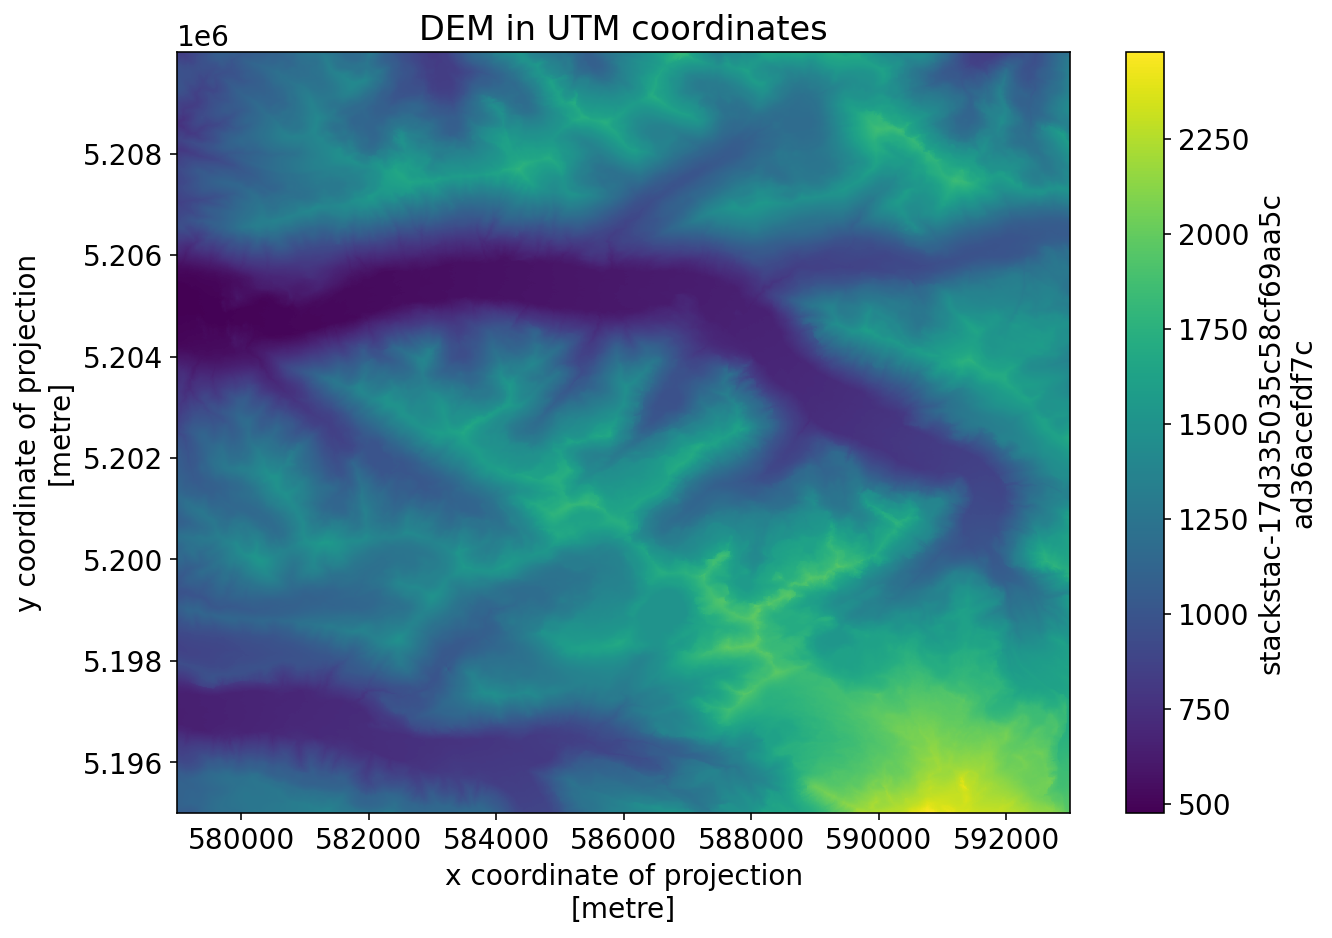

In [11]:
dem_raster.plot()
_ = plt.title("DEM in UTM coordinates")

### Define GRD parameters

In [12]:
grd_account_name = "sentinel1euwest"
grd_storage_container = "s1-grd"
grd_product_folder = f"{grd_storage_container}/{product_folder}"
grd_local_path = os.path.join(tmp_dir, product_folder)

### Retrieve Sentinel-1 GRD

In [13]:
grd_token = planetary_computer.sas.get_token(
    grd_account_name, grd_storage_container
).token
grd_fs = adlfs.AzureBlobFileSystem(grd_account_name, credential=grd_token)
grd_fs.ls(f"{grd_product_folder}/manifest.safe")

['s1-grd/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048/manifest.safe']

In [14]:
grd_fs.get(grd_product_folder, grd_local_path, recursive=True)
!ls -d {grd_local_path}

/tmp/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048


### Process

#### GTC

Here we compute the geometric terrain correction.

Input parameters:
- `product_urlpath`: product path
- `measurement_group`: band to be processed in the form {swath}/{polarization} (see [xarray-sentinel](https://pypi.org/project/xarray-sentinel/) for more details)
- `dem_urlpath`: path to the input DEM. sarsen supports all DEMs supported by GDAL/Proj for ECEF-translation. 
- `interp_method`: interpolation method, sarsen supports all interpolation methods supported by [xarray.Dataset.interp](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html)
- `chunks`: dask chunks
- `output_urlpath`: output path

The output is the input SAR image resampled on DEM coordinates

In [15]:
gtc_path = os.path.basename(product_folder) + ".GTC.tif"

gtc = apps.terrain_correction(
    grd_local_path,
    measurement_group,
    dem_path,
    interp_method="nearest",
    override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
    chunks=2048,
    output_urlpath=gtc_path,
)

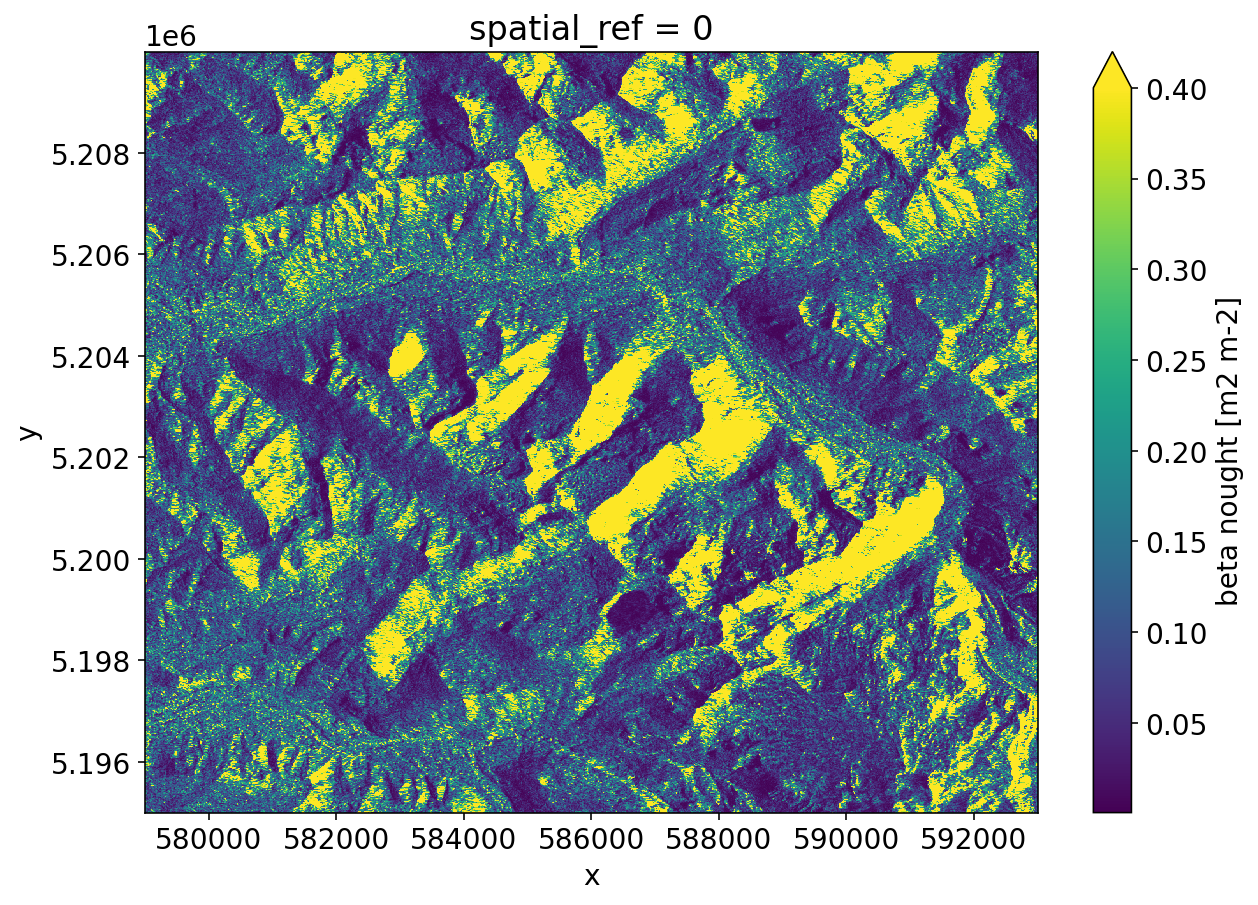

In [16]:
_ = gtc.plot(vmax=0.4)

#### RTC
`sarsen` implements the radiometric terrain-correction [Gamma Flattening](https://ieeexplore.ieee.org/document/5752845) algorithm.

#### Input parameters
- `correct_radiometry`: `correct_radiometry`: default `None`. If `correct_radiometry=None`the radiometric terrain correction is not applied. `correct_radiometry=gamma_bilinear` applies the gamma flattening classic algorithm using bilinear interpolation to compute the weights. `correct_radiometry=gamma_nearest` applies the gamma flattening using nearest neighbours instead of bilinear interpolation. 'gamma_nearest' significantly reduces the processing time.
- `grouping_area_factor`: scaling factor for the size of the image pixel where the areas are summed. By default, the `grouping_area_factor` is `(1, 1)`, which corresponds to Sentinel-1 input product pixel size. The `grouping_area_factor` shall be increased if the DEM resolution is lower than the Sentinel-1 input product resolution to avoid gaps and distortions the normalization factor. It can be also used to to speed up the computation or  the DEM resolution is lower than the Sentinel-1 input product resolution.  


**Note**: The `grouping_area_factor` can be increased (i) to speed up the processing or (ii) when the input DEM resolution is low. The Gamma Flattening usually works properly if the pixel size of the input DEM is much smaller than the pixel size of the input Sentinel-1 product. Otherwise, the output may have radiometric distortions. This problem can be avoided by increasing the `grouping_area_factor`. Be aware that `grouping_area_factor` too high may degrade the final result.

In [17]:
import warnings

warnings.filterwarnings("ignore", "divide by zero", RuntimeWarning)

In [18]:
rtc_path = os.path.basename(grd_local_path) + ".RTC.tif"

rtc = apps.terrain_correction(
    grd_local_path,
    measurement_group,
    dem_path,
    interp_method="nearest",
    override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
    correct_radiometry="gamma_nearest",
    output_urlpath=rtc_path,
    grouping_area_factor=(1, 1),
)

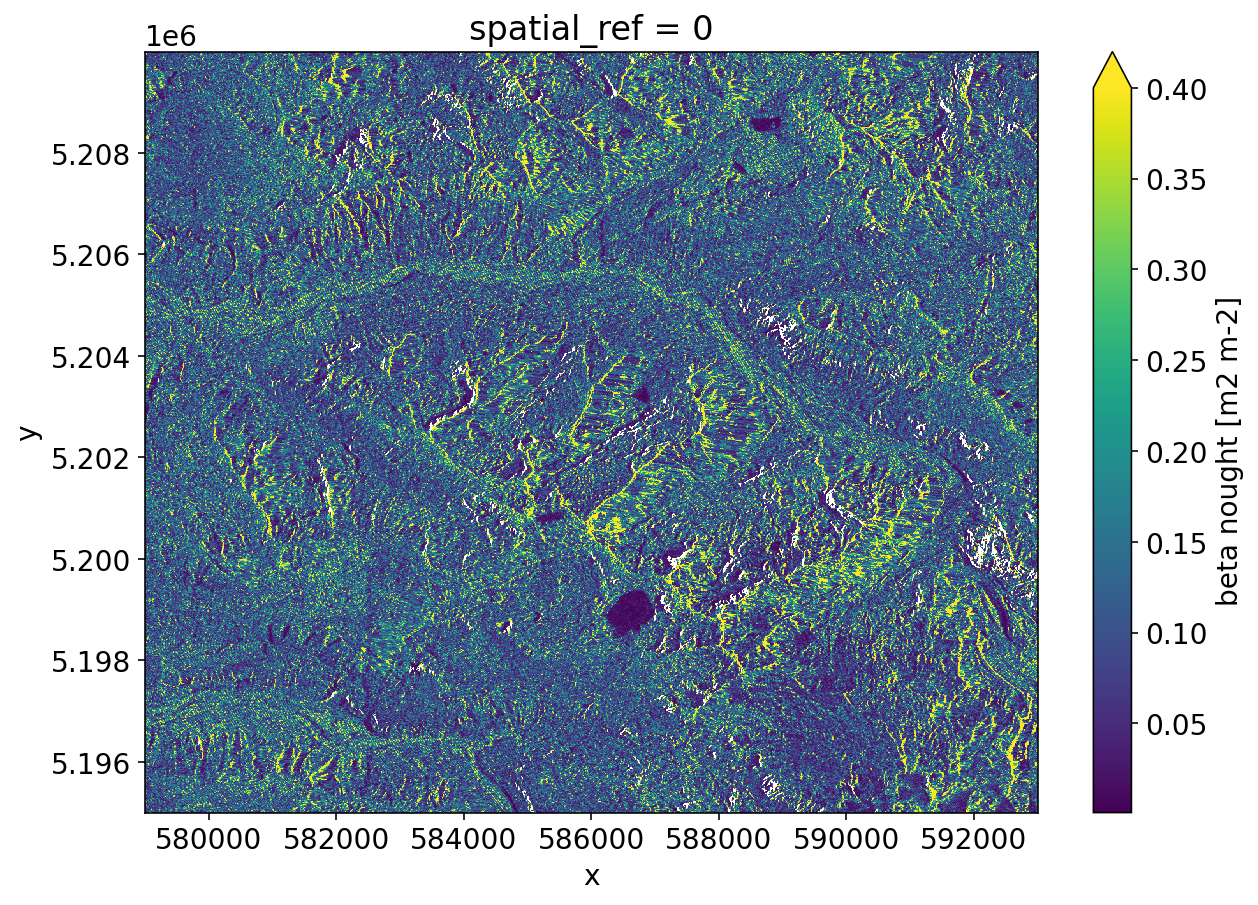

In [19]:
_ = rtc.plot(vmax=0.4)

### Gamma vs Local incidence Angle

The backscattering depends on the ground material, the roughness and the local incidence angle. Small values of the local incidence angle correspond usually to higher values of backscattering, while high values of radar incidence angle corresponds to zones with low backscattering. The aim of the radiometric terrain correction is to remove the contribution due to the local incidence angle. 
For evaluating the goodness of the radiometric correction we will compare the incidence angle versus backscattering before and after the correction.

#### Compute local incidence angle and ellipsoid incidence angle

![SNOWFALL](https://forum.step.esa.int/uploads/default/original/3X/e/3/e372bf0efa0133c63977111b15614bc0c7d96fd8.png)

In [20]:
dem = scene.open_dem_raster(dem_path)


orbit_ecef = xr.open_dataset(
    grd_local_path,
    engine="sentinel-1",
    group=f"{measurement_group}/orbit",
    override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
)
dem_ecef = scene.convert_to_dem_ecef(dem, source_crs=t_srs)
dem_ecef_1 = scene.convert_to_dem_ecef(dem + 1, source_crs=t_srs)
ellissoid_normal = dem_ecef - dem_ecef_1

TypeError: convert_to_dem_ecef() got an unexpected keyword argument 'source_crs'

In [ ]:
acquisition = apps.simulate_acquisition(
    dem_ecef, orbit_ecef.position, coordinate_conversion=None, correct_radiometry=True
)
oriented_area = scene.compute_dem_oriented_area(dem_ecef)
dem_normal = -oriented_area / np.sqrt(xr.dot(oriented_area, oriented_area, dims="axis"))

# compute direction target sensor
orbit_interpolator = orbit.OrbitPolyfitIterpolator.from_position(orbit_ecef.position)
position_ecef = orbit_interpolator.position()
velocity_ecef = orbit_interpolator.velocity()
acquisition = geocoding.backward_geocode(dem_ecef, orbit_ecef.position, velocity_ecef)
slant_range = np.sqrt((acquisition.dem_distance**2).sum(dim="axis"))
dem_direction = acquisition.dem_distance / slant_range

In [ ]:
angle = np.arccos(xr.dot(dem_normal, dem_direction, dims="axis"))

In [ ]:
ellipsoid_incidence = np.arccos(xr.dot(ellissoid_normal, dem_direction, dims="axis"))

#### Load Data

In [ ]:
ellipsoid_incidence = ellipsoid_incidence.load()
angle = angle.load()
gtc = gtc.load()
rtc = rtc.load()

#### GTC and RTC distribution of foreslope, backslope, and flat terrain 

We classify taking into account the local incidence angle and the ellipsoid incidence angle
 the image in three zone:
- foreslope, small incidence angles that correspond to high backscattering zones.
- flat terrain
- backslope, big incidence angles that correspond to low backscattering zones


We will show that the radiometric correction mitigate the effect of the foreslope and backslope.

In [ ]:
# foreslope backslope and flat terrain
gtc_foreslope = xr.where(angle < ellipsoid_incidence - 0.20, gtc, np.nan)
gtc_backslope = xr.where(angle > ellipsoid_incidence + 0.20, gtc, np.nan)
gtc_flat = xr.where(
    (angle < ellipsoid_incidence + 0.20) & (angle > ellipsoid_incidence - 0.20),
    gtc,
    np.nan,
)

rtc_foreslope = xr.where(angle < ellipsoid_incidence - 0.20, rtc, np.nan)
rtc_backslope = xr.where(angle > ellipsoid_incidence + 0.20, rtc, np.nan)
rtc_flat = xr.where(
    (angle < ellipsoid_incidence + 0.20) & (angle > ellipsoid_incidence - 0.20),
    rtc,
    np.nan,
)

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 9))

dem_raster.plot(ax=axes[0])
axes[0].grid(c="red")
axes[0].set_title("DEM")

gtc.plot(ax=axes[1], vmax=0.4)
axes[1].grid(c="red")
axes[1].set_title("GTC")


angle.plot(ax=axes[2])
axes[2].grid(c="red")
axes[2].set_title("Incidence Angle")

plt.tight_layout()

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 9))

gtc_backslope.plot(ax=axes[0], vmax=0.4)
axes[0].grid(c="red")
axes[0].set_title("GTC basckslope")

gtc_foreslope.plot(ax=axes[1], vmax=0.4)
axes[1].grid(c="red")
axes[1].set_title("GTC foreslope")


gtc_flat.plot(ax=axes[2], vmax=0.4)
axes[2].grid(c="red")
axes[2].set_title("GTC flat terrain")


plt.tight_layout()

#### GTC and RTC distribution of foreslope backslope and flat terrain in db

In [ ]:
gtc_backslope_db = np.log(gtc_backslope)
gtc_foreslope_db = np.log(gtc_foreslope)
gtc_flat_db = np.log(gtc_flat)

rtc_backslope_db = np.log(rtc_backslope)
rtc_foreslope_db = np.log(rtc_foreslope)
rtc_flat_db = np.log(rtc_flat)

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12))

gtc_backslope_db_h = xr.plot.hist(
    gtc_backslope_db,
    range=[-10, 5],
    bins=50,
    color=[0, 1, 0, 0.4],
    density=True,
    ax=axes[0],
    label="backslope",
)
gtc_foreslope_db_h = xr.plot.hist(
    gtc_foreslope_db,
    range=[-10, 5],
    bins=50,
    color=[1, 0, 0, 0.4],
    density=True,
    ax=axes[0],
    label="foreslope",
)
gtc_flat_db_h = xr.plot.hist(
    gtc_flat_db,
    range=[-10, 5],
    bins=50,
    color=[0, 0, 1, 0.4],
    density=True,
    ax=axes[0],
    label="flat",
)

rtc_backslope_db_h = xr.plot.hist(
    rtc_backslope_db,
    range=[-10, 5],
    bins=50,
    color=[0, 1, 0, 0.4],
    density=True,
    ax=axes[1],
    label="backslope",
)
rtc_foreslope_db_h = xr.plot.hist(
    rtc_foreslope_db,
    range=[-10, 5],
    bins=50,
    color=[1, 0, 0, 0.4],
    density=True,
    ax=axes[1],
    label="foreslope",
)
rtc_flat_db_h = xr.plot.hist(
    rtc_flat_db,
    range=[-10, 5],
    bins=50,
    color=[0, 0, 1, 0.4],
    density=True,
    ax=axes[1],
    label="flat",
)
axes[0].legend()
axes[1].legend()

axes[0].set_title("GTC distribution")
axes[0].set_xlabel("beta DB")

axes[1].set_title("RTC distribution")
axes[1].set_xlabel("gamma_T DB")

**Before the radiometic correction the distribution of backslope flat terrain and foreslope are separate, after they  overlap completely.**

#### RTC and GTC scatterplots incidence angle vs backcattering

We compare the incidence_angle-backscattering scatterplots of the GTC and the RTC to show that in the former there is a correlation between the incidence angle and backscattering, while in the RTC the correlation has been removed.

In [ ]:
def makeColours(vals):
    colours = np.zeros((len(vals), 3))
    norm = Normalize(vmin=vals.min(), vmax=vals.max())

    # Can put any colormap you like here.
    colours = [cm.ScalarMappable(norm=norm, cmap="plasma").to_rgba(val) for val in vals]

    return colours


def plot_density(x, y, ax=None):
    if ax is None:
        ax = plt
    mask = np.logical_and(np.isfinite(y), np.isfinite(x))
    samples = np.stack([x[mask], y[mask]])

    densObj = kde(samples)
    colours = makeColours(densObj.evaluate(samples))
    fig = ax.scatter(samples[0], samples[1], color=colours)
    return fig

In [ ]:
gtc_db = np.log(gtc).load()
rtc_db = np.log(rtc).load()
angle = angle.load()

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12))

fig = plot_density(
    angle[::10, ::10].data.ravel(), gtc_db[::10, ::10].data.ravel(), ax=axes[0]
)
fig = plot_density(
    angle[::10, ::10].data.ravel(), rtc_db[::10, ::10].data.ravel(), ax=axes[1]
)

axes[0].set_title("GTC")
axes[0].set_ylabel("beta DB")
axes[0].set_xlabel("local incidence angle")

axes[1].set_title("RTC")
axes[1].set_ylabel("gamma_T DB")
axes[1].set_xlabel("local incidence angle")

**Note that in the first plot there is a clear correlation between the angle of incidence and backscattering, while in the second graph there is no correlation.**